# Import necessary modules and load sql engine

In [341]:
import sqlalchemy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sqlalchemy import create_engine
from IPython.display import display_html
from datetime import datetime
from pytz import timezone

In [342]:
%load_ext sql
%sql postgresql://postgres@localhost/homedata
engine = create_engine('postgresql://postgres@localhost/homedata')

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# Declare configuration variables

In [361]:
# constant variables
fc = {'work':'black', 
      'eating':'green', 
      'toilet':'purple', 
      'fitness':'red', 
      'sleep':'skyblue', 
      'personal_hygiene':'grey', 
      'shower':'blue', 
      'relax':'orange', 
      'cooking':'pink', 
      'phonecall':'teal', 
      'leave_home':'brown'}

# visualization targets and period
target_period = '144 hours'

# Fetch sensor data from TimescaleDB

In [362]:
# MTS Sensor data fetch
hroom1_result = %sql SELECT * FROM sensor_data WHERE db_insert_time > now() - interval '{target_period}' AND room = 'hroom-1'
hroom2_result = %sql SELECT * FROM sensor_data WHERE db_insert_time > now() - interval '{target_period}' AND room = 'hroom-2'
act_result = %sql SELECT data_gen_time, activity, start_end FROM user_activity WHERE data_gen_time > now() - interval '{target_period}'

sensor_df1 = hroom1_result.DataFrame()
sensor_df2 = hroom2_result.DataFrame()
act_df = act_result.DataFrame()

sensor_df1.sort_values('db_insert_time', ascending = True, inplace = True)
sensor_df2.sort_values('db_insert_time', ascending = True, inplace = True)
act_df.sort_values('data_gen_time', ascending = True, inplace = True)

# Avg value fetch for sensor data
r1s1 = %sql SELECT db_insert_time, (select avg(a) from unnest(sound1) as a) FROM sensor_data WHERE db_insert_time > now() - interval '{target_period}' AND room = 'hroom-1'
r1s2 = %sql SELECT db_insert_time, (select avg(a) from unnest(sound2) as a) FROM sensor_data WHERE db_insert_time > now() - interval '{target_period}' AND room = 'hroom-1'
r2s1 = %sql SELECT db_insert_time, (select avg(a) from unnest(sound1) as a) FROM sensor_data WHERE db_insert_time > now() - interval '{target_period}' AND room = 'hroom-2'
r2s2 = %sql SELECT db_insert_time, (select avg(a) from unnest(sound2) as a) FROM sensor_data WHERE db_insert_time > now() - interval '{target_period}' AND room = 'hroom-2'

r1s1_df = r1s1.DataFrame()
r1s2_df = r1s2.DataFrame()
r2s1_df = r2s1.DataFrame()
r2s2_df = r2s2.DataFrame()

r1s1_df.sort_values('db_insert_time', ascending = True, inplace = True)
r1s2_df.sort_values('db_insert_time', ascending = True, inplace = True)
r2s1_df.sort_values('db_insert_time', ascending = True, inplace = True)
r2s2_df.sort_values('db_insert_time', ascending = True, inplace = True)

 * postgresql://postgres@localhost/homedata
386948 rows affected.
 * postgresql://postgres@localhost/homedata
386043 rows affected.
 * postgresql://postgres@localhost/homedata
202 rows affected.
 * postgresql://postgres@localhost/homedata
386948 rows affected.
 * postgresql://postgres@localhost/homedata
386948 rows affected.
 * postgresql://postgres@localhost/homedata
386043 rows affected.
 * postgresql://postgres@localhost/homedata
386043 rows affected.


# Merge data into a single dataframe in a normalized scale

## Merge Dataframe along the same timescale

### Time-series friendly merging: pd.merge_asof()

#### Sound Sensor

In [363]:
r1s1_df.rename(columns={'avg':'snd11_roadside'}, inplace=True)
r1s2_df.rename(columns={'avg':'snd12_bed'}, inplace=True)
r2s1_df.rename(columns={'avg':'snd21_kitchen'}, inplace=True)
r2s2_df.rename(columns={'avg':'snd22_desk'}, inplace=True)

r1_df = pd.merge_asof(r1s1_df, r1s2_df, on='db_insert_time', tolerance=pd.Timedelta('5ms'))
r2_df = pd.merge_asof(r2s1_df, r2s2_df, on='db_insert_time', tolerance=pd.Timedelta('5ms'))

snd_df = pd.merge_asof(r1_df, r2_df, on='db_insert_time', tolerance=pd.Timedelta('1s'))
snd_df.rename(columns={'db_insert_time':'time'}, inplace=True)
snd_df.dropna(inplace=True)

#### Other Sensors

In [364]:
sensor_df1.drop(columns=['data_gen_time', 'room', 'sound1', 'sound2', 'airquality', 'dustconcentration'], inplace=True)
sensor_df2.drop(columns=['data_gen_time', 'room', 'sound1', 'sound2', 'airquality', 'dustconcentration'], inplace=True)

sensor_df1.rename(columns={'db_insert_time':'time', 'temperature':'tmp1', 'humidity':'hmd1', 'light':'light1', 'motion':'mot1'}, inplace=True)
sensor_df2.rename(columns={'db_insert_time':'time', 'temperature':'tmp2', 'humidity':'hmd2', 'light':'light2', 'motion':'mot2'}, inplace=True)

sensor_df = pd.merge_asof(snd_df, sensor_df1, on='time', tolerance=pd.Timedelta('1s'))
sensor_df = pd.merge_asof(sensor_df, sensor_df2, on='time', tolerance=pd.Timedelta('1s'))
sensor_df.dropna(inplace=True)

#### Addition of Weekday / Weekend

In [365]:
# add weekdays / weekend info into the DataFrame
# weekno = sensor_df['time'][0].to_pydatetime().weekday() # if weekno <5 ? weekday : weekend
sensor_df['weekend'] = sensor_df.apply(lambda x: int(x['time'].to_pydatetime().weekday()/5), axis=1)

# add hour info into the DataFrame
sensor_df['hour'] = sensor_df.apply(lambda x: float(x['time'].to_pydatetime().hour/24), axis=1)

#### Synchronize time scale of activity dataframe to sensor dataframe

In [52]:
# drop activity rows earlier than the head of sensor_df

# drop activity rows later than the tail of sensor_df


/Users/heesuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


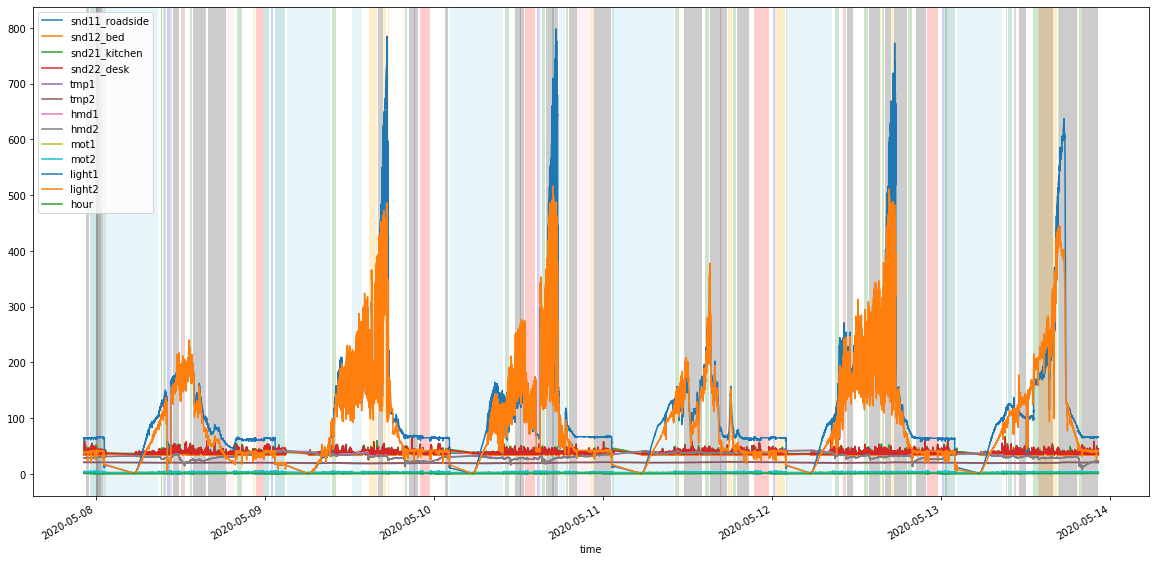

In [366]:
# initialize plotting
ax = plt.gca()

# add sensor values to the target plot
sensor_df.plot(kind='line', x='time', y='snd11_roadside', ax=ax)
sensor_df.plot(kind='line', x='time', y='snd12_bed', ax=ax)
sensor_df.plot(kind='line', x='time', y='snd21_kitchen', ax=ax)
sensor_df.plot(kind='line', x='time', y='snd22_desk', ax=ax)
sensor_df.plot(kind='line', x='time', y='tmp1', ax=ax)
sensor_df.plot(kind='line', x='time', y='tmp2', ax=ax)
sensor_df.plot(kind='line', x='time', y='hmd1', ax=ax)
sensor_df.plot(kind='line', x='time', y='hmd2', ax=ax)
sensor_df.plot(kind='line', x='time', y='mot1', ax=ax)
sensor_df.plot(kind='line', x='time', y='mot2', ax=ax)
sensor_df.plot(kind='line', x='time', y='light1', ax=ax)
sensor_df.plot(kind='line', x='time', y='light2', ax=ax)
sensor_df.plot(kind='line', x='time', y='hour', ax=ax)

# add activity periods to the target plot
act_stack = {} # stack implemented as a dict which stores unclosed/unfinished activities to be visualized

start_T = ''
end_T = ''

log = {'err':'', 'debug':''}

# converts numpy.datetime64 to datetime.
# datetime is compatible with pandas.timestamp with timezone.
def convT(T_dt64):
    T_ts = (T_dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    return datetime.fromtimestamp(T_ts).astimezone(timezone('US/Eastern'))

# visualize starts here
for index, row in act_df.iterrows():    
    act = row['activity']
    
    if row['start_end'] == 'start':
        if act in act_stack.keys():
            log['err'] += 'The given activity is already in the activity stack.' # error message
        else:
            act_stack[act] = {}
            log['debug'] += '{} is added to act_stack.\n'.format(act)
            #print('{} is added to act_stack.'.format(act))

            start_T = row['data_gen_time']

            if index == act_df.size-1: # if this is the last row
                end_T = convT(sensor_df.tail(1)['time'].values[0])
                log['debug'] += "act={}, start_T={}, end_T={}, color={}\n".format(act, str(start_T), str(end_T), fc[act])
                ax.axvspan(start_T, end_T, label = act, facecolor=fc[act], alpha=0.2)
                act_stack.pop(act)
                log['debug'] += '[1] act_stack.pop({})\n'.format(act)
            else:
                act_stack[act]['start_T'] = start_T
    else: # row['start_end'] == 'end'
        end_T = row['data_gen_time']
        
        if act in act_stack.keys():
            act_stack[act]['end_T'] = end_T
            log['debug'] += "act={}, start_T={}, end_T={}, color={}\n".format(act, str(act_stack[act]['start_T']), str(act_stack[act]['end_T']), fc[act])
            ax.axvspan(act_stack[act]['start_T'], act_stack[act]['end_T'], label = act, facecolor=fc[act], alpha=0.2)
            act_stack.pop(act)
            log['debug'] += '[2] act_stack.pop({})\n'.format(act)
        else:
            if start_T == '':
                start_T = convT(sensor_df.head(1)['time'].values[0])
            
            log['debug'] += "act={}, start_T={}, end_T={}, color={}\n".format(act, str(start_T), str(end_T), fc[act])
            ax.axvspan(start_T, end_T, label = act, facecolor=fc[act], alpha=0.2)
            
if len(act_stack.keys()) != 0:
    log['debug'] += "len(act_stack.keys()) = {}\n".format(len(act_stack.keys()))
    log['debug'] += "act_stack = {}\n".format(str(act_stack))
    
    for act in act_stack.keys():
        end_T = convT(sensor_df.tail(1)['time'].values[0])
        ax.axvspan(start_T, end_T, label = act, facecolor=fc[act], alpha=0.2)


# plot
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

## Normalize Dataframe values along all columns
To facilitate any machine learning training phases, the sensor values will be normalized into a range [0, 1], considering the possible data range of each sensor.

#### Valid data range of each used sensors:
* Sound Phidget: 34~102 dB (SPL)
* Humidity/Temperature Phidget: -30 ~ 80C, 10 ~ 95%
* Precision Light Phidget: 1000 lux
* Motion Phidget: Not found but maybe 0~10

#### How to normalize each sensor:
* Sound Phidget: (x-30)/50, assuming that sound level never goes beyond 80dB
* Humidity: x/95, since x-10<0 is found
* Temperature: (x+20)/70, assuming that temp. never goes down to -20C either up to 50C
* Light: x/1000
* Motion: x/10

In [367]:
sensor_df['snd11_roadside'] = sensor_df.apply(lambda x: (x['snd11_roadside']-30)/50, axis=1)
sensor_df['snd12_bed'] = sensor_df.apply(lambda x: (x['snd12_bed']-30)/50, axis=1)
sensor_df['snd21_kitchen'] = sensor_df.apply(lambda x: (x['snd21_kitchen']-30)/50, axis=1)
sensor_df['snd22_desk'] = sensor_df.apply(lambda x: (x['snd22_desk']-30)/50, axis=1)
sensor_df['tmp1'] = sensor_df.apply(lambda x: (x['tmp1']+20)/70, axis=1)
sensor_df['tmp2'] = sensor_df.apply(lambda x: (x['tmp2']+20)/70, axis=1)
sensor_df['hmd1'] = sensor_df.apply(lambda x: x['hmd1']/95, axis=1)
sensor_df['hmd2'] = sensor_df.apply(lambda x: x['hmd2']/95, axis=1)
sensor_df['light1'] = sensor_df.apply(lambda x: x['light1']/1000, axis=1)
sensor_df['light2'] = sensor_df.apply(lambda x: x['light2']/1000, axis=1)
sensor_df['mot1'] = sensor_df.apply(lambda x: x['mot1']/10, axis=1)
sensor_df['mot2'] = sensor_df.apply(lambda x: x['mot2']/10, axis=1)
sensor_df

,time,snd11_roadside,snd12_bed,snd21_kitchen,snd22_desk,tmp1,hmd1,light1,mot1,tmp2,hmd2,light2,mot2,weekend,hour
0,2020-05-07 22:19:54.111575-04:00,0.112980,0.090066,0.125199,0.115151,0.579129,0.300179,0.06409,0.249023,0.585029,0.302947,0.03906,0.239700,0,0.916667
1,2020-05-07 22:19:57.473695-04:00,0.113832,0.090506,0.125769,0.127575,0.579029,0.300684,0.06415,0.248947,0.585029,0.302947,0.03903,0.244583,0,0.916667
2,2020-05-07 22:19:58.590782-04:00,0.114485,0.089217,0.118430,0.119727,0.579129,0.300684,0.06412,0.247681,0.585029,0.302568,0.03906,0.250595,0,0.916667
3,2020-05-07 22:20:00.861969-04:00,0.113706,0.101555,0.122844,0.126247,0.578929,0.300926,0.06415,0.248154,0.585129,0.302705,0.03906,0.242569,0,0.916667
4,2020-05-07 22:20:06.581213-04:00,0.115635,0.082554,0.133055,0.122825,0.579029,0.300926,0.06409,0.248978,0.585029,0.302389,0.03903,0.248520,0,0.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203526,2020-05-13 22:19:22.644924-04:00,0.121126,0.085793,0.131500,0.124229,0.576900,0.245947,0.06613,0.249756,0.584357,0.249442,0.04095,0.237259,0,0.916667
203527,2020-05-13 22:19:23.807187-04:00,0.117686,0.093401,0.135185,0.117152,0.576900,0.246074,0.06613,0.247589,0.584271,0.249495,0.04105,0.248245,0,0.916667
203528,2020-05-13 22:19:24.925538-04:00,0.111688,0.087842,0.133858,0.123137,0.576800,0.245747,0.06613,0.249603,0.584357,0.249495,0.04095,0.235718,0,0.916667
203529,2020-05-13 22:19:26.042977-04:00,0.123834,0.090261,0.125661,0.114479,0.576800,0.246074,0.06604,0.244904,0.584357,0.249295,0.04092,0.250397,0,0.916667


#### Validate the data in range [0,1]

In [370]:
sensor_df[(sensor_df[['snd11_roadside', 'snd12_bed', 'snd21_kitchen', 'snd22_desk', 'tmp1', 'hmd1', 'light1', 'mot1', 'tmp2', 'hmd2', 'light2', 'mot2', 'weekend', 'hour']] > 1).any(1)]
#(sensor_df[['snd11_roadside', 'snd12_bed', 'snd21_kitchen', 'snd22_desk', 'tmp1', 'hmd1', 'light1', 'mot1', 'tmp2', 'hmd2', 'light2', 'mot2', 'weekend', 'hour']] > 0).all(1)

,time,snd11_roadside,snd12_bed,snd21_kitchen,snd22_desk,tmp1,hmd1,light1,mot1,tmp2,hmd2,light2,mot2,weekend,hour


# Visualize the MTS data with activity data labels

/Users/heesuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


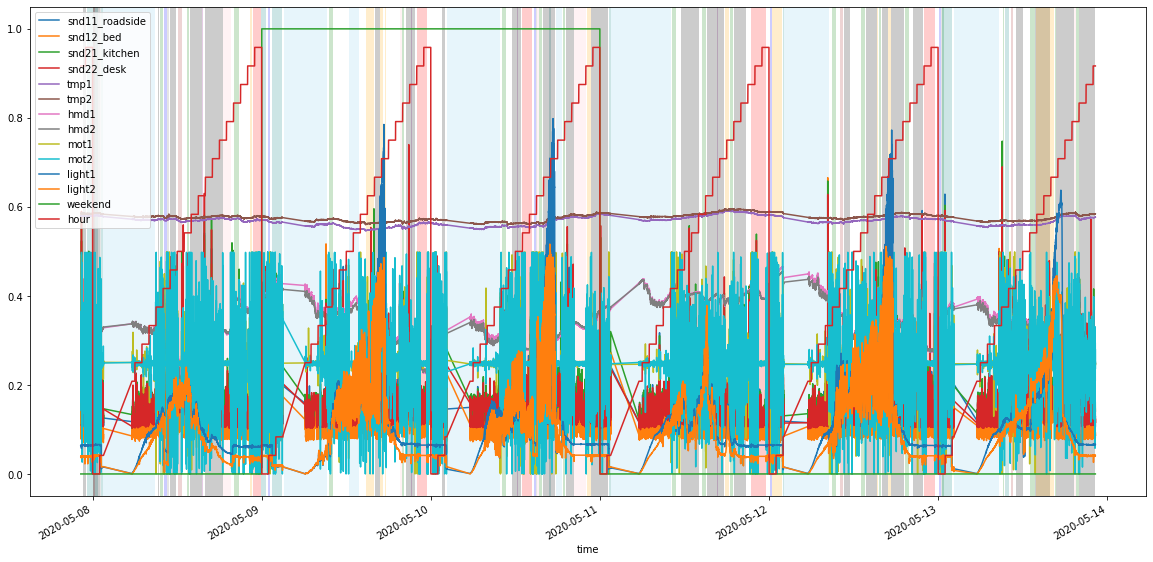

In [371]:
# initialize plotting
ax = plt.gca()

# add sensor values to the target plot
sensor_df.plot(kind='line', x='time', y='snd11_roadside', ax=ax)
sensor_df.plot(kind='line', x='time', y='snd12_bed', ax=ax)
sensor_df.plot(kind='line', x='time', y='snd21_kitchen', ax=ax)
sensor_df.plot(kind='line', x='time', y='snd22_desk', ax=ax)
sensor_df.plot(kind='line', x='time', y='tmp1', ax=ax)
sensor_df.plot(kind='line', x='time', y='tmp2', ax=ax)
sensor_df.plot(kind='line', x='time', y='hmd1', ax=ax)
sensor_df.plot(kind='line', x='time', y='hmd2', ax=ax)
sensor_df.plot(kind='line', x='time', y='mot1', ax=ax)
sensor_df.plot(kind='line', x='time', y='mot2', ax=ax)
sensor_df.plot(kind='line', x='time', y='light1', ax=ax)
sensor_df.plot(kind='line', x='time', y='light2', ax=ax)
sensor_df.plot(kind='line', x='time', y='weekend', ax=ax)
sensor_df.plot(kind='line', x='time', y='hour', ax=ax)

# add activity periods to the target plot
act_stack = {} # stack implemented as a dict which stores unclosed/unfinished activities to be visualized

start_T = ''
end_T = ''

log = {'err':'', 'debug':''}

# converts numpy.datetime64 to datetime.
# datetime is compatible with pandas.timestamp with timezone.
def convT(T_dt64):
    T_ts = (T_dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    return datetime.fromtimestamp(T_ts).astimezone(timezone('US/Eastern'))

# visualize starts here
for index, row in act_df.iterrows():    
    act = row['activity']
    
    if row['start_end'] == 'start':
        if act in act_stack.keys():
            log['err'] += 'The given activity is already in the activity stack.' # error message
        else:
            act_stack[act] = {}
            log['debug'] += '{} is added to act_stack.\n'.format(act)
            #print('{} is added to act_stack.'.format(act))

            start_T = row['data_gen_time']

            if index == act_df.size-1: # if this is the last row
                end_T = convT(sensor_df.tail(1)['time'].values[0])
                log['debug'] += "act={}, start_T={}, end_T={}, color={}\n".format(act, str(start_T), str(end_T), fc[act])
                ax.axvspan(start_T, end_T, label = act, facecolor=fc[act], alpha=0.2)
                act_stack.pop(act)
                log['debug'] += '[1] act_stack.pop({})\n'.format(act)
            else:
                act_stack[act]['start_T'] = start_T
    else: # row['start_end'] == 'end'
        end_T = row['data_gen_time']
        
        if act in act_stack.keys():
            act_stack[act]['end_T'] = end_T
            log['debug'] += "act={}, start_T={}, end_T={}, color={}\n".format(act, str(act_stack[act]['start_T']), str(act_stack[act]['end_T']), fc[act])
            ax.axvspan(act_stack[act]['start_T'], act_stack[act]['end_T'], label = act, facecolor=fc[act], alpha=0.2)
            act_stack.pop(act)
            log['debug'] += '[2] act_stack.pop({})\n'.format(act)
        else:
            if start_T == '':
                start_T = convT(sensor_df.head(1)['time'].values[0])
            
            log['debug'] += "act={}, start_T={}, end_T={}, color={}\n".format(act, str(start_T), str(end_T), fc[act])
            ax.axvspan(start_T, end_T, label = act, facecolor=fc[act], alpha=0.2)
            
if len(act_stack.keys()) != 0:
    log['debug'] += "len(act_stack.keys()) = {}\n".format(len(act_stack.keys()))
    log['debug'] += "act_stack = {}\n".format(str(act_stack))
    
    for act in act_stack.keys():
        end_T = convT(sensor_df.tail(1)['time'].values[0])
        ax.axvspan(start_T, end_T, label = act, facecolor=fc[act], alpha=0.2)


# plot
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

### Color Mapping to Activities
* Work = Black
* Eating = Green
* Toilet = Purple
* Fitness = Red
* Sleep = Skyblue
* Personal_hygiene = Grey
* Shower = Blue
* Relax = Orange
* Cooking = Pink
* Phonecall = Teal

# Construct (X,Y) pairs out of the dataframe for DNN models

## Transformation from dataframe to (X,Y) pairs

### Label each tuple of sensor data with an activity annotation

In [372]:
NULL = -1
NORM_ACT_SESS = 0
OPEN_END_SESS = 1
ONGOING_SESS = 2

act_map = {'work':0, 
           'eating':1, 
           'toilet':2, 
           'fitness':3, 
           'sleep':4, 
           'personal_hygiene':5, 
           'shower':6, 
           'relax':7, 
           'cooking':8, 
           'phonecall':9, 
           'leave_home':10, 
           'null':11}
act_sess_list = []
act_session = {'act':'', 'start':'', 'end':'', 'cls':NULL}

for index, row in act_df.iterrows():
    if row['start_end'] == 'start':
        if index == 0: # open-ended start of an activity
            act_session['act'] = row['activity']
            act_session['start'] = row['data_gen_time']
            act_session['cls'] = OPEN_END_SESS
            act_sess_list.append(act_session.copy())
            act_session = {'act':'', 'start':'', 'end':'', 'cls':NULL}
        else: # normal start - start of an activity to be ended
            act_session['act'] = row['activity']
            act_session['start'] = row['data_gen_time']
    else: # row['start_end'] == 'end'
        if act_session['start'] == '': # an activity started but not shown in the dataframe
            act_session['act'] = row['activity']
            act_session['end'] = row['data_gen_time']
            act_session['cls'] = ONGOING_SESS
            act_sess_list.append(act_session.copy())
            act_session = {'act':'', 'start':'', 'end':'', 'cls':NULL}
        else: # normal end - end of an activity whose start was already added to act_session dict
            act_session['end'] = row['data_gen_time']
            act_session['cls'] = NORM_ACT_SESS
            act_sess_list.append(act_session.copy())
            act_session = {'act':'', 'start':'', 'end':'', 'cls':NULL}

def getAct(test_t): # test_t <- TimeStamp
    result_act = 'null'
    
    for act_sess in act_sess_list:
        if act_sess['cls'] == NORM_ACT_SESS:
            if test_t >= act_sess['start'] and test_t < act_sess['end']:
                result_act = act_sess['act']
                return act_map[result_act]
        elif act_sess['cls'] == OPEN_END_SESS:
            if test_t >= act_sess['start']:
                result_act = act_sess['act']
                return act_map[result_act]
        else: # ONGOING SESS
            if test_t < act_sess['end']:
                result_act = act_sess['act']
                return act_map[result_act]
    
    return act_map[result_act]

In [373]:
sensor_df['act'] = sensor_df['time'].apply(getAct)
sensor_df

,time,snd11_roadside,snd12_bed,snd21_kitchen,snd22_desk,tmp1,hmd1,light1,mot1,tmp2,hmd2,light2,mot2,weekend,hour,act
0,2020-05-07 22:19:54.111575-04:00,0.112980,0.090066,0.125199,0.115151,0.579129,0.300179,0.06409,0.249023,0.585029,0.302947,0.03906,0.239700,0,0.916667,0
1,2020-05-07 22:19:57.473695-04:00,0.113832,0.090506,0.125769,0.127575,0.579029,0.300684,0.06415,0.248947,0.585029,0.302947,0.03903,0.244583,0,0.916667,0
2,2020-05-07 22:19:58.590782-04:00,0.114485,0.089217,0.118430,0.119727,0.579129,0.300684,0.06412,0.247681,0.585029,0.302568,0.03906,0.250595,0,0.916667,0
3,2020-05-07 22:20:00.861969-04:00,0.113706,0.101555,0.122844,0.126247,0.578929,0.300926,0.06415,0.248154,0.585129,0.302705,0.03906,0.242569,0,0.916667,0
4,2020-05-07 22:20:06.581213-04:00,0.115635,0.082554,0.133055,0.122825,0.579029,0.300926,0.06409,0.248978,0.585029,0.302389,0.03903,0.248520,0,0.916667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203526,2020-05-13 22:19:22.644924-04:00,0.121126,0.085793,0.131500,0.124229,0.576900,0.245947,0.06613,0.249756,0.584357,0.249442,0.04095,0.237259,0,0.916667,0
203527,2020-05-13 22:19:23.807187-04:00,0.117686,0.093401,0.135185,0.117152,0.576900,0.246074,0.06613,0.247589,0.584271,0.249495,0.04105,0.248245,0,0.916667,0
203528,2020-05-13 22:19:24.925538-04:00,0.111688,0.087842,0.133858,0.123137,0.576800,0.245747,0.06613,0.249603,0.584357,0.249495,0.04095,0.235718,0,0.916667,0
203529,2020-05-13 22:19:26.042977-04:00,0.123834,0.090261,0.125661,0.114479,0.576800,0.246074,0.06604,0.244904,0.584357,0.249295,0.04092,0.250397,0,0.916667,0


### Transform each DataFrame row into a tuple of (x,y)

In [374]:
subset_x = sensor_df[['snd11_roadside', 'snd12_bed', 'snd21_kitchen', 'snd22_desk', 'tmp1', 'hmd1', 'light1', 'mot1', 'tmp2', 'hmd2', 'light2', 'mot2', 'weekend', 'hour']]
subset_y = sensor_df['act']
home_dset_features = subset_x.values.tolist()
home_dset_labels = subset_y.tolist()

type(home_dset_labels), len(home_dset_labels), type(home_dset_features), len(home_dset_features)

(list, 203531, list, 203531)

# Dataset Preparation for 2D-CNN, including 2D-ResNet
Considering that each time gap between two data points is 1.2s in average, 50 data points are expected to compose one-minute long 3D data. By adding two zero-valued features and reshaping the features, we can compose each datapoint of a 50x4x4 cubic shape. This transformation should be optimal to CNN-like network architectures because it can be used as the input of any CNN-like models as-is. It is also possible to use 50x7x2 cubic shape, not adding two null features with increased number of parameters. However, squared shape should be much more effective to capture correlated patterns of input features because a bigger kernel (e.g., 3x3) can be used.

### Adding null features

In [375]:
sensor_df['null-1'] = 0
sensor_df['null-2'] = 0
sensor_df = sensor_df.reindex(columns = ['time', 'snd11_roadside', 'snd12_bed', 'snd21_kitchen', 'snd22_desk', 'tmp1', 'hmd1', 'light1', 'mot1', 'tmp2', 'hmd2', 'light2', 'mot2', 'weekend', 'hour', 'null-1', 'null-2', 'act'])
sensor_df

,time,snd11_roadside,snd12_bed,snd21_kitchen,snd22_desk,tmp1,hmd1,light1,mot1,tmp2,hmd2,light2,mot2,weekend,hour,null-1,null-2,act
0,2020-05-07 22:19:54.111575-04:00,0.112980,0.090066,0.125199,0.115151,0.579129,0.300179,0.06409,0.249023,0.585029,0.302947,0.03906,0.239700,0,0.916667,0,0,0
1,2020-05-07 22:19:57.473695-04:00,0.113832,0.090506,0.125769,0.127575,0.579029,0.300684,0.06415,0.248947,0.585029,0.302947,0.03903,0.244583,0,0.916667,0,0,0
2,2020-05-07 22:19:58.590782-04:00,0.114485,0.089217,0.118430,0.119727,0.579129,0.300684,0.06412,0.247681,0.585029,0.302568,0.03906,0.250595,0,0.916667,0,0,0
3,2020-05-07 22:20:00.861969-04:00,0.113706,0.101555,0.122844,0.126247,0.578929,0.300926,0.06415,0.248154,0.585129,0.302705,0.03906,0.242569,0,0.916667,0,0,0
4,2020-05-07 22:20:06.581213-04:00,0.115635,0.082554,0.133055,0.122825,0.579029,0.300926,0.06409,0.248978,0.585029,0.302389,0.03903,0.248520,0,0.916667,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203526,2020-05-13 22:19:22.644924-04:00,0.121126,0.085793,0.131500,0.124229,0.576900,0.245947,0.06613,0.249756,0.584357,0.249442,0.04095,0.237259,0,0.916667,0,0,0
203527,2020-05-13 22:19:23.807187-04:00,0.117686,0.093401,0.135185,0.117152,0.576900,0.246074,0.06613,0.247589,0.584271,0.249495,0.04105,0.248245,0,0.916667,0,0,0
203528,2020-05-13 22:19:24.925538-04:00,0.111688,0.087842,0.133858,0.123137,0.576800,0.245747,0.06613,0.249603,0.584357,0.249495,0.04095,0.235718,0,0.916667,0,0,0
203529,2020-05-13 22:19:26.042977-04:00,0.123834,0.090261,0.125661,0.114479,0.576800,0.246074,0.06604,0.244904,0.584357,0.249295,0.04092,0.250397,0,0.916667,0,0,0


### Export preprocessed data to CSV file

In [376]:
sensor_df.to_csv('act_mts_data.csv')